# Introduction to Data Science

We'll be using Titanic data, from [Vanderbilt University's Department of Biostatistics](https://hbiostat.org/data/repo/titanic3.csv) and establish a model for predicting whether a given passenger would have survived on that fateful night in April 15, 1912.





<!-- Using this data
provides information about the survival of passengers on the Titanic and characteristics about the passengers such as age and ticket class. , the tutorial will -->

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("./data/titanic3.csv")
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [22]:
# Check mem. usage

data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 589.5 KB


In [23]:
data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [24]:
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})

<Axes: xlabel='survived', ylabel='fare'>

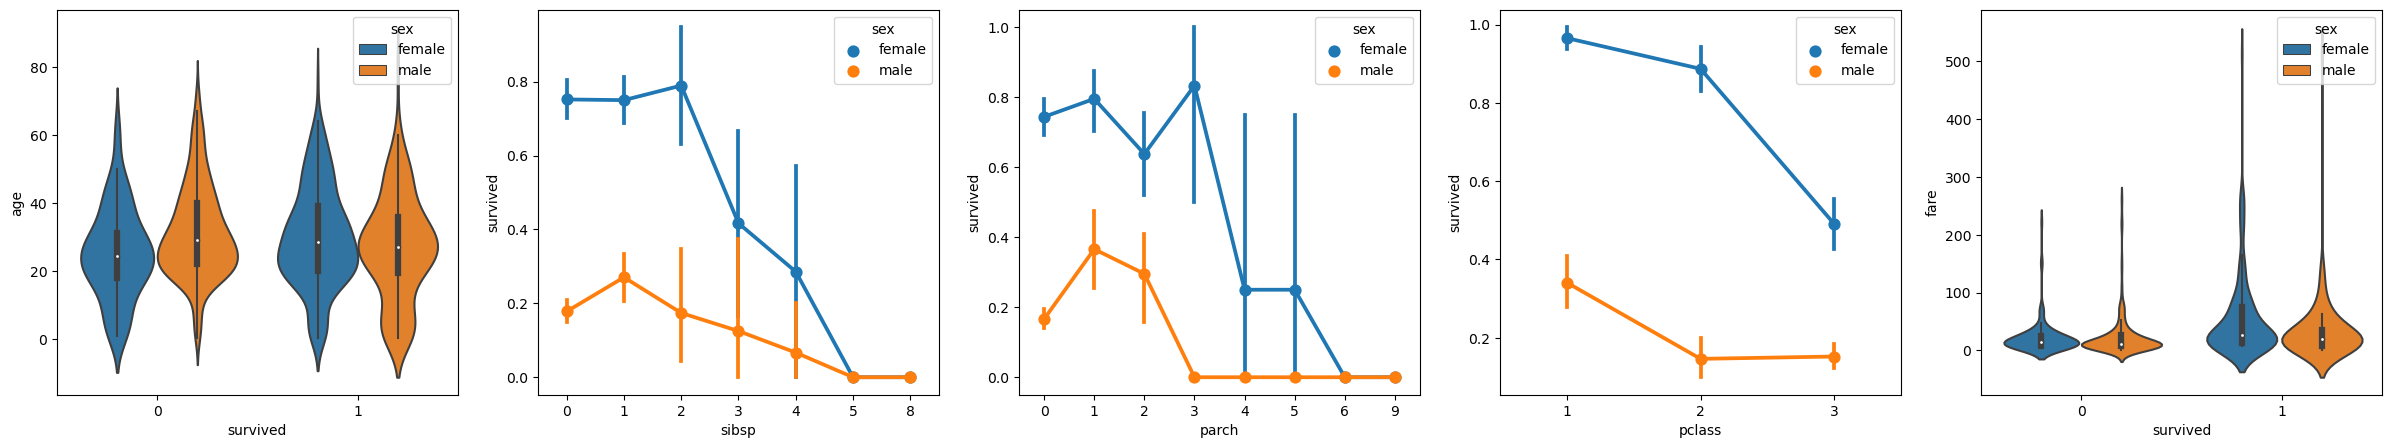

In [25]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5))

sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

In [26]:
data.replace({'male': 1, 'female': 0}, inplace=True)

In [27]:
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


In [28]:
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN
relatives,0.201719


In [29]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

## Train & Evaluate

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

In [32]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [33]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885
